In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sporgboost.preprocessing import onehot_encode, shuffle
from sporgboost.trees import AxisAlignedDecisionTree, SparseRandomDecisionTree
from sklearn.tree import DecisionTreeClassifier
sktree = DecisionTreeClassifier()
model_aa = AxisAlignedDecisionTree()
model_sr = SparseRandomDecisionTree(d = 2, s = 3)


In [2]:
# Dataset for testing
X, y = load_iris(return_X_y = True)

# Set seed to be able to reproduce
np.random.seed(1234)
    
# Preprocessing
y = onehot_encode(y)
X, y = shuffle(X, y)

In [144]:
import numpy as np
from numba import njit
from sporgboost.utils import row_mean

@njit(cache=True)
def pca(X):
    # Step 1: Center data
    X_ = X - row_mean(X)

    # Get SVD decomposition for eigenvalues/vectors
    U, _, V = np.linalg.svd(X_, full_matrices=False)

    # SVD flip method
    max_abs_cols = np.argmax(np.abs(U), axis=0).astype('int')
    signs = np.sign(np.diag(U[max_abs_cols, :]))
    U *= signs
    V *= signs.reshape((-1, 1))
    return V.T

pca(X)

array([[ 0.36138659,  0.65658877, -0.58202985, -0.31548719],
       [-0.08452251,  0.73016143,  0.59791083,  0.3197231 ],
       [ 0.85667061, -0.17337266,  0.07623608,  0.47983899],
       [ 0.3582892 , -0.07548102,  0.54583143, -0.75365743]])

In [152]:
a = (X - X.mean(axis=0)) @ pca(X)
b = (X) @ pca(X)

def test_pca(data_iris):
    # This test confirms that PCA series transformed
    # on original or de-meaned data only differ by a constant
    # which can be baked into the node split
    X, _ = data_iris

    assert np.var(a - b, axis=0) < 1e-16

array([ True,  True,  True,  True])

In [132]:
from sklearn.decomposition import PCA

model_sklearn = PCA(svd_solver='full')
model_sklearn.fit(X)
model_sklearn.components_

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102],
       [-0.58202985,  0.59791083,  0.07623608,  0.54583143],
       [-0.31548719,  0.3197231 ,  0.47983899, -0.75365743]])

In [143]:
def test_pca_sklearn(X):
    V = pca(X)

    model_sklearn = PCA(svd_solver='full')
    model_sklearn.fit(X)

    X_pca = (X - X.mean(axis=0)) @ V.T

    # Weights can be flipped based on the SVD engine, flip
    # signs and check
    X_pca_sklearn =  model_sklearn.transform(X)
    return np.all(np.abs(X_pca - X_pca_sklearn) < 1e-8)

test_pca_sklearn(X)


True

In [89]:
%timeit pca(X)

25.6 µs ± 658 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [90]:
%timeit model_sklearn.fit(X)

152 µs ± 1.63 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102],
       [-0.58202985,  0.59791083,  0.07623608,  0.54583143],
       [-0.31548719,  0.3197231 ,  0.47983899, -0.75365743]])

In [111]:
model_sklearn.transform(X)

array([[ 8.90815198e-01, -3.44644444e-02, -9.94693289e-03,
         1.53484666e-01],
       [ 9.84934510e-01, -1.24817854e-01, -6.21144083e-02,
         1.69496255e-01],
       [ 1.97153105e+00, -1.79727904e-01,  1.08424662e-01,
         2.36790934e-01],
       [-2.82053775e+00, -8.94613845e-02,  2.57892158e-01,
         4.81431065e-02],
       [-8.74540408e-03, -7.23081905e-01,  2.81141431e-01,
         5.61891788e-03],
       [-2.63198939e+00, -1.96961225e-01,  4.07710791e-02,
         1.23983306e-01],
       [-2.56231991e+00,  3.67718857e-01, -7.84942051e-02,
         1.41727423e-02],
       [-2.86624165e+00,  6.93644716e-02, -1.64332307e-01,
        -1.62598446e-01],
       [ 2.99000842e-01, -3.48897806e-01,  1.05816605e-02,
         5.11811717e-02],
       [ 3.49992004e+00,  4.60674099e-01, -5.73182243e-01,
         1.40227954e-01],
       [ 1.36428712e-01, -3.14032438e-01, -1.77242766e-01,
        -3.29419128e-02],
       [-2.99740655e+00, -3.41926057e-01,  1.92509212e-01,
      

In [93]:
model_sklearn.transform(X) - (X - X.mean(axis=0)) @ pca(X).T

array([[ 1.4426333 , -0.29195956, -0.14827542,  0.80804885],
       [ 1.61396742, -0.3266341 , -0.26785758,  0.90401665],
       [ 3.15597451, -0.63870489, -0.06400438,  1.76772683],
       [-4.04005858,  0.81762548,  0.87531365, -2.26292066],
       [ 0.24329445, -0.04923784,  0.54063182,  0.13627427],
       [-3.69739034,  0.74827641,  0.41057706, -2.07098507],
       [-3.86872446,  0.78295095,  0.18729371, -2.16695287],
       [-4.38272682,  0.88697454,  0.06135915, -2.45485626],
       [ 0.58596269, -0.1185869 , -0.03098215,  0.32820987],
       [ 5.04064985, -1.02012475, -1.59493756,  2.8233726 ],
       [ 0.24329445, -0.04923784, -0.37613658,  0.13627427],
       [-4.2113927 ,  0.85230001,  0.75979497, -2.35888846],
       [ 5.04064985, -1.02012475, -0.18078332,  2.8233726 ],
       [ 0.75729682, -0.15326143,  0.19370281,  0.42417766],
       [-3.69739034,  0.74827641,  0.85677079, -2.07098507],
       [-0.44204203,  0.08946029, -0.59764535, -0.24759692],
       [ 3.841311  , -0.

In [46]:
model_sklearn.predict(X_test[[31,54,84,94]])

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [47]:
model_aa.predict(X_test[[31,54,84,94]])

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [45]:
model_aa.tree.right.left.right.value

array([[0., 1., 0.]])

[Text(0.4, 0.875, 'X[2] <= 2.6\ngini = 0.442\nsamples = 50\nvalue = [[34, 16]\n[35, 15]\n[31, 19]]'),
 Text(0.2, 0.625, 'gini = 0.0\nsamples = 16\nvalue = [[0, 16]\n[16, 0]\n[16, 0]]'),
 Text(0.6, 0.625, 'X[2] <= 4.85\ngini = 0.329\nsamples = 34\nvalue = [[34, 0]\n[19, 15]\n[15, 19]]'),
 Text(0.4, 0.375, 'X[3] <= 1.6\ngini = 0.078\nsamples = 16\nvalue = [[16, 0]\n[1, 15]\n[15, 1]]'),
 Text(0.2, 0.125, 'gini = 0.0\nsamples = 15\nvalue = [[15, 0]\n[0, 15]\n[15, 0]]'),
 Text(0.6, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [[1, 0]\n[1, 0]\n[0, 1]]'),
 Text(0.8, 0.375, 'gini = 0.0\nsamples = 18\nvalue = [[18, 0]\n[18, 0]\n[0, 18]]')]

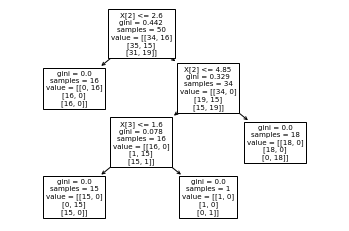

In [4]:
from sklearn import tree
tree.plot_tree(model_sklearn)

In [19]:
t = model_aa.tree.right.left.left
print(t.is_leaf())
print(t.proj)
print(t.split)
print(t.value)


True
None
None
[[0. 0. 1.]]


In [17]:
X_train[(X_train[:, 2] > 2.6) & (X_train[:, 2] <= 4.85), 0]

array([5.4, 5.5, 5.7, 5.7, 6.3, 4.9, 5. , 6.1, 5.5, 6.7, 6.6, 6.8, 7. ,
       5.5, 5.6, 5.5])

In [28]:
model_sklearn.predict(X_test[[35, 91], :])

array([[1., 0., 0.],
       [1., 0., 0.]])

In [29]:
model_aa.predict(X_test[[35, 91], :])

array([[0., 0., 1.],
       [0., 1., 0.]])

In [3]:
model_sr.fit(X, y)

In [4]:
model_aa.fit(X, y)

In [7]:
sktree.fit(X, y)

DecisionTreeClassifier()

In [8]:
np.all(model_sr.predict(X) == sktree.predict(X))

True